# Dirichlet Sampler

Prior to this, the rpeorting bias has been represented by a stochastic poisson process. However this does not ensure that the reporting factors across the week average to unity (conserving case numbers), resulting the compensating errors observed in the fixed bias formulation. In such cases, the net reporting factor will decrease while $R_{t}$ increases (or vise versa) so that the overall number of predicted cases is approximately correct, but other inferred parameter values are inaccurate.

We therefore use describe this reporting noise via a 7-element Dirichlet distribution, which will therefore require a mean of unity, and hence conserve case numbers through the application of the reporting bias. The reporting factor at any given time step will be sampled from this distribution, and used to scale the ground truth cases to give the true number of cases. As the gamma prior is no longer conjugate, this is replaced by a categorical prior.

## Dirichlet Noise Bias

### Dirichlet Distribution

The Dirichlet distribution defines a probability density for a vector valued input having the same characteristics as a multinomial parameter. It has support (the set of points where it has non-zero values) over

$$
x_{1}, ... , x_{K}, \, where \, x_{i} \in [0, 1], \, and \, \sum_{i=1}^{K}x_{i} = 1
$$

where $K$ is the number of variables. Its probability density function has the following form:

$$
Dir(\mathbf{x} | \mathbf{\omega}) = \frac{1}{Beta(\mathbf{\omega})} \prod_{i=1}^{K} x_{i}^{\, \omega_{i} -1}, \; where \; Beta(\mathbf{\omega}) = \frac{\prod_{i=1}^{K} \Gamma(\omega_{i})}{\Gamma\left(\sum_{i=1}^{K} \omega_{i}\right)} \; and \; \mathbf{\omega} = (\omega_{1}, ... , \omega_{k})
$$

The Dirichlet distribution is parameterized by the vector $\mathbf{\omega}$, which has the same number of elements $K$ as our multinomial parameter $\mathbf{x}$. 

In our case $K = 7$, and as we require the reporting factors $\alpha_{i}$ to sum to 7, we may define $x_{i} = \alpha_{i} / 7$.

### Categorical Prior

*This confuses me as this is a discrete prior for a continuous variable? Still, based on previous work, the effect of the prior may be negligible anyway.*



### Conditional Posterior Derivation

The conditional posterior for $\alpha_{i}$ is given by:

$$
P(\alpha_{i} | I_{t} , C_{t}) = \prod_{t} Dir(C_{t} / I_{t}| \alpha_{i[t]} ) \times Gamma(\alpha_{i} | a, b)
$$

where the Dirichlet distribution has replaced the Poisson distribution used in `constant_R_sampler.ipynb`.

### Timeseries sampling

In terms of the inference, the posterior distribution for the true number of cases $I_{t}$ would be based on this Dirichlet distribution for the reporting factor (replacing the poisson $Po(\alpha_{i[t]} I_{t})$ in $P(C_{t} | \alpha_{i[t]} I_{t})$).

Each time step $I_{t}$ is therefore sampled independantly from the following distribution:

$$
P(I_{t} | C_{t}, \alpha_{i}, R_{t}) =  Po(I_{t} | R_{t} \Lambda_{t}) \times Dir(C_{t} / I_{t} | \alpha_{i})
$$

N.B For $t=0$, $\Lambda_{t}$ is not defined, and therefore we take $\Lambda_{0} = C_{0}\alpha_{0}$ as an estimate of the seed cases instead during inference.

### $R_{t}$ sampling 

This is not affected by the noise source, hence we will still use a sliding window to assume $R_{t}$ has been constant for the previous 7 days, and compute the probability of a given $R_{t}$ value based on data from this period. This gives a conditional posterior distribution of the following form:

$$
P(R_{t} | I_{t}) = \prod_{t'=max(0, t-6)}^{t}\biggl[ P(I_{t'} | R_{t}) \biggr] P(R_{t})
$$

which we may write in the form of a Gamma distribution (see `varying_Rt_sampler.ipynb` for details):


$$
P(R_{t} | I_{t}) \propto Gamma \Biggl(a_{R} + \sum_{t'=t-6}^{t} I_{t'}, b_{R} + \sum_{t'=t-6}^{t}\Lambda_{t'} \Biggr) 
$$

# Dirichlet Sampler

## Synthetic Data Generation

Here we use a renewal model to generate synthetic data, which we will subsequently perform inference on.

In [1]:
import datetime
import numpy as np
import pandas as pd
import scipy.stats as ss
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = '14'

from synthetic_data import RenewalModel, Reporter

100%|██████████| 500/500 [00:00<00:00, 154349.89it/s]


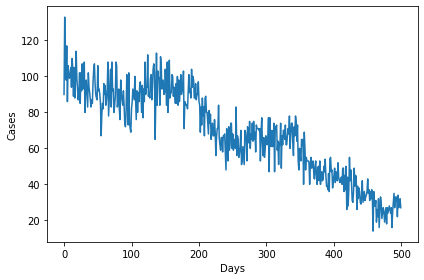

In [2]:
# Simulate Renewal Model
time_steps = 500; N_0 = 100; R_0=0.99; seed=31
start_date = '01/01/2020'; bias_method = 'dirichlet'
bias = [0.5, 1.4, 1.2, 1.1, 1.1, 1.1, 0.6]  # Always given with monday first

np.random.seed(seed)
model = RenewalModel(R0=R_0)
model.simulate(T=time_steps, N_0=N_0)
model.plot()

In [3]:
# Report unbiased and biased data
rep = Reporter(model.case_data, start_date=start_date)  # Start on Mon 6th for ease

truth_df = rep.unbiased_report()
bias_df = rep.fixed_bias_report(bias=bias, method=bias_method)

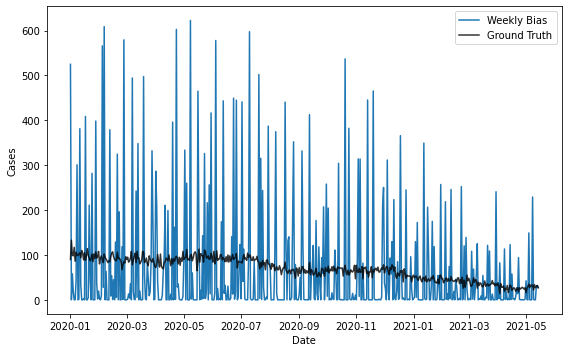

In [43]:
# Plot bias in data
fig, axs = plt.subplots(1, figsize=(8,5))

bias_df.plot(x='Date', y='Confirmed', ax=axs, color='tab:blue', label = 'Weekly Bias')
truth_df.plot(x='Date', y='Confirmed', ax=axs, color='black', label = 'Ground Truth', alpha=0.8)
# fig.patch.set_facecolor('white')  # Overrides VSCode dark mode default
plt.xlabel("Date"); plt.ylabel("Cases")
plt.legend();  plt.tight_layout()
# plt.savefig("../images/synthetic_inference/"
#             + f"biased_data_{bias_method}_T_{time_steps}_N0_{N_0}_R0_{R_0}_seed_{seed}.png")
plt.savefig("series.png")

True bias: [0.5, 1.4, 1.2, 1.1, 1.1, 1.1, 0.6]
Ave sample: [0.52, 1.4, 1.22, 1.04, 1.14, 1.07, 0.6]
Sum of averages: 7.000000000000001


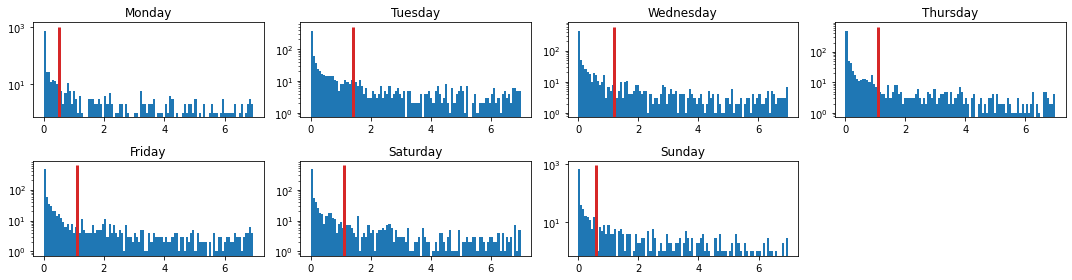

In [45]:
N = 1000; weights = [i / 7 for i in bias]
array = np.ndarray((7, N))
for i in range(N):
    array[:, i] = 7 * np.random.dirichlet(weights)

print("True bias: " + str([round(x, 2) for x in bias]))
print("Ave sample: " + str([round(x, 2) for x in np.mean(array, axis=1)]))
print("Sum of averages: " + str(sum(np.mean(array, axis=1))))

fig, axs = plt.subplots(2, 4, figsize=(15, 4))
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
for i in range(7):
    axs.flatten()[i].hist(array[i, :], bins = 100); axs.flatten()[i].set_yscale('log')
    axs.flatten()[i].set_title(weekdays[i])
    axs.flatten()[i].vlines(x=bias[i], ymin=0, ymax=axs.flatten()[i].get_ylim()[1], color='tab:red', linewidth=3)
axs.flatten()[7].axis('off'); plt.gcf().patch.set_facecolor('white'); plt.tight_layout()

The Dirichlet distribution is not appropriate to generate synthetic data, as the width of the distribution is far too large (generating the vast amounts of noise shown in the example timeseries above).

We will therefore continue to use the Poisson distribution to generate data for this model, but assume the bias values are sampled from a Dirichlet distribution.